### Feature Engineering and Selection:

- Objective: engineer new features and analyze their importance
- Method: first use Univariate tests to discard poor features (important when dealing with many features)
    Then, use recursive feature elimination and feature importances to get a feeling for ranking among features left


Dilemma: should we tune a model before feeding it to RFECV? Answer: first loosely tune models and then use regularized decision trees for a potentially more rigorouse answer:
            https://arxiv.org/pdf/1201.1587.pdf

In [3]:
%load_ext autoreload

%autoreload 2

In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
from math import sqrt

In [5]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, average_precision_score
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.utils.fixes import signature
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [7]:
os.listdir('../../../../mkt_camp_data')

['df_pickle.pickle',
 'df_pickle_w_all_stats.pickle',
 'df_pickle_w_time_stats.pickle',
 'final_df_pickle.pickle']

In [23]:
#Loading final df from feature engineering notebook
final_df = pd.read_pickle('../../../../mkt_camp_data/final_df_pickle.pickle')
#final_df = final_df.drop(columns = ['Date'])

In [24]:
final_df = final_df[['Date','duration']]

In [25]:
def scale_noncat_only(X):
    
    indx = X.Date
    X.drop(columns='Date', inplace=True)
    
    X_temp_noncat = X.select_dtypes(exclude=['int8'])
    X_temp_noncat = X_temp_noncat.drop(X_temp_noncat.filter(regex="-categorical").columns, axis=1)
    
    
    scaler = preprocessing.StandardScaler().fit(X_temp_noncat)
    X_transformed = pd.DataFrame(scaler.transform(X_temp_noncat), columns = X_temp_noncat.columns)
    
    X = X_transformed.merge(X, left_index=True, right_index=True, how='inner', suffixes=('', '_rightdf'))
    X = X.drop(X.filter(regex="_rightdf").columns, axis=1)
    
    X.index = indx
    
    return X, scaler

In [26]:
final_df, scaler = scale_noncat_only(final_df)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [27]:
def prep_df(df):
    y = df['duration']
    #X = df.drop(df.filter(regex='y').columns, axis=1)
    y = y.shift(1)
    #X = df.drop(columns='duration')
    #Dropping features based on y
    #X = X.drop(X.filter(regex="cust_acquisition_flag").columns, axis=1) 
    #X = X.drop(X.filter(regex="cust_retention_flag").columns, axis=1)
    #X = X.drop(X.filter(regex="prospect_conversion_flag").columns, axis=1)
    
    #Dropping linearly dependent features
    
    #X = df.drop(columns = ['new_lead'])

    X = df.copy()
     
    names = list(df.columns)
    return X, y, names

In [28]:
X,y,names = prep_df(final_df)

In [33]:
y.head()

Date
2008-05-05    0.010
2008-05-05   -0.422
2008-05-05   -0.125
2008-05-05   -0.414
2008-05-05    0.188
Name: duration, dtype: float64

In [34]:
X.head()

,duration
Date,
2008-05-05,-0.422
2008-05-05,-0.125
2008-05-05,-0.414
2008-05-05,0.188
2008-05-05,-0.233


In [31]:
y = y.iloc[1:]

In [32]:
X = X.iloc[1:]

In [16]:
for i in X.columns:
    print(i)

pdays
campaign
previous
emp.var.rate
age
duration-rolling-avg-10
previous-rolling-avg-10
old_prospect_y-rolling-avg-10
duration


In [35]:
X.shape

(41187, 1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), test_size = 0.20, random_state=4)

In [37]:
X_test.shape

(8238, 1)

In [38]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(32949, 1, 1) (32949,) (8238, 1, 1) (8238,)


In [39]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [40]:
# fit network
history = model.fit(X_train, y_train, epochs=2, 
                    batch_size=72, validation_data=(X_test, y_test), 
                    verbose=2, shuffle=False)

Train on 32949 samples, validate on 8238 samples
Epoch 1/2
 - 4s - loss: 1.0207 - val_loss: 0.9168
Epoch 2/2
 - 3s - loss: 1.0185 - val_loss: 0.9166


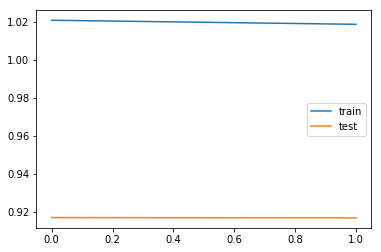

In [42]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [43]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [45]:
from numpy import concatenate
# invert scaling for forecast
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [46]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [47]:
len(inv_y)

8238

In [48]:
np.count_nonzero(np.isnan(inv_y))

0

In [51]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 248.234


In [52]:
inv_y.mean()

256.2448409808206

Time Series Feature Engineering

In [394]:
def create_rolling_features(df, names, func, window):
    
    new_names = [i+'-rolling-'+str(func)+'-'+str(window) for i in names]
    
    if func == 'avg':    
        df[new_names] = df[names].rolling(window, win_type = 'triang').mean()
    elif func == 'sum':
        df[new_names] = df[names].rolling(window, win_type = 'triang').sum()
    
    return df

In [395]:
customer_attr = ['age', 'duration', 'campaign', 'y','previous', 'pdays', 'new_prospect_y', 
            'old_prospect_y', 'prev_subscr_flag', 'cust_retention_flag', 
            'cust_acquisition_flag', 'prospect_conversion_flag']

In [396]:
#economic indicators - longer term windows
econ_attr = ['cons_conf', 'ind_turnover', 'major_purch_expect', 'major_purch_opportu', 
             'unempl_expect', 'inflation_delta_expect', 'economy_expect', 'economy_past', 
             'financial_past', 'savings_delta_expect', 'household_debt_ratio', 
             'savings_expect', 'emplmnt_industry_index', 'railway_passengers']

In [397]:
df = create_rolling_features(df, customer_attr, 'avg', 10)
df = create_rolling_features(df, customer_attr, 'avg', 30)
df = create_rolling_features(df, customer_attr, 'avg', 60)

NameError: name 'df' is not defined

In [398]:
df = create_rolling_features(df, customer_attr, 'sum', 10)
df = create_rolling_features(df, customer_attr, 'sum', 30)
df = create_rolling_features(df, customer_attr, 'sum', 60)

NameError: name 'df' is not defined

In [ ]:
df = create_rolling_features(df, econ_attr, 'avg', 45)
df = create_rolling_features(df, econ_attr, 'avg', 90)

In [391]:
#loading df
X, y, names = prep_df(final_df)

Feature Importance:

Starting with an exploration of the most important features with univariate methods and RFE (with CV)

Univariate Feature Selection

In [392]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

In [393]:
def kbest(X,y, score_func, k):
    #Use f_regression or mutual_info_regression as scoring function
    test = SelectKBest(score_func=score_func, k=k)
    fit = test.fit(X, y)
    # summarize scores
    np.set_printoptions(precision=3)
    return sorted(list(zip(names,list(fit.scores_))), key=lambda tup:tup[1], reverse=True) 

In [10]:
best_cols = kbest(X,y, f_regression, 'all')

In [11]:
best_cols

[('duration-rolling-sum-10', 658.2322727850463),
 ('duration-rolling-avg-10', 658.2322727850224),
 ('duration-rolling-avg-30', 472.36586990655206),
 ('duration-rolling-sum-30', 472.365869906534),
 ('duration-rolling-avg-60', 465.1982134214848),
 ('duration-rolling-sum-60', 465.19821342142563),
 ('campaign', 212.8221977194653),
 ('campaign-rolling-sum-60', 162.57484634813886),
 ('campaign-rolling-avg-60', 162.5748463481367),
 ('FDI', 127.0960409440427),
 ('campaign-rolling-sum-30', 108.96647338777834),
 ('campaign-rolling-avg-30', 108.96647338777736),
 ('prev_subscr_flag', 83.11115440608762),
 ('Foreign exchange reserves', 80.87898740255453),
 ('Government debt', 78.98053221763733),
 ('prev_subscr_flag-rolling-avg-30', 78.91354586820017),
 ('prev_subscr_flag-rolling-sum-30', 78.91354586820017),
 ('campaign-rolling-sum-10', 75.00787008485212),
 ('campaign-rolling-avg-10', 75.00787008484477),
 ('previous-rolling-avg-60', 74.51842520207875),
 ('previous-rolling-sum-60', 74.51842520207872),

In [12]:
#among the top 70 indicators, many are economic indicators that are highly related to one another
#to avoid redundancy we will pick only the top 10 economic indicators
rfe_test1 = [i[0] for i in best_cols][:40]

In [13]:
X[rfe_test1].shape

(41188, 40)

Feature Importances Via Decision Tree Regression

In [15]:
X_test1 = X[rfe_test1]

In [17]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [18]:
def test_regression(X, y):
    lr = LinearRegression()
    lr.fit(X,y)
    scores = cross_val_score(lr,X,y,cv=10, scoring = 'r2')
    print('CV R2 : %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_test1,y, test_size = 0.20, random_state=4)

In [20]:
model = RandomForestRegressor(max_depth = 20, min_samples_split = 1000, random_state = 4)

In [21]:
model.fit(X_train,y_train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=1000,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=4, verbose=0, warm_start=False)

In [22]:
r2_score(y_test, model.predict(X_test))

0.016742790411616193

In [23]:
#Second test with less features
rfe_test2 = [i[0] for i in best_cols][:20]
X_test2 = X[rfe_test2]

In [24]:
X_test2 = scale_noncat_only(X_test2)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_test2,y, test_size = 0.20, random_state=4)

In [26]:
model = RandomForestRegressor(max_depth = 20, min_samples_split = 1000, random_state = 4)

In [27]:
model.fit(X_train,y_train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=1000,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=4, verbose=0, warm_start=False)

In [28]:
r2_score(y_test, model.predict(X_test))

0.016912919525384873

In [29]:
#loading df
X, y, names = prep_df(final_df)

In [30]:
#Third test with less features
rfe_test3 = [i[0] for i in best_cols][:70]
X_test3 = X[rfe_test3]

In [31]:
X_test3 = scale_noncat_only(X_test3)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_test3,y, test_size = 0.20, random_state=4)

In [33]:
model = RandomForestRegressor(max_depth = 20, min_samples_split = 1000, random_state = 4)

In [34]:
model.fit(X_train,y_train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=1000,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=4, verbose=0, warm_start=False)

In [35]:
r2_score(y_test, model.predict(X_test))

0.01978955349149969

Too many predictors are monthly while call duration depends on specific customer interaction

We give up regression methods as a way to predict call duration - will focus on autocorrelation models instead

In [37]:
from pandas.plotting import lag_plot

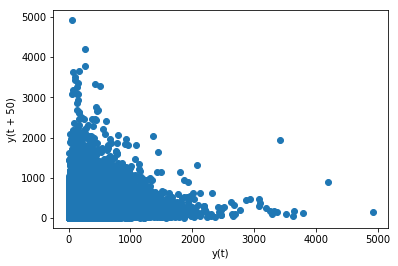

In [194]:
lag_plot(y, lag=50)

In [46]:
oldp_idx = X[X['old_prospect']==1].index

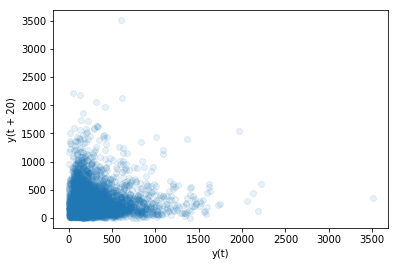

In [208]:
lag_plot(y[oldp_idx], alpha=0.1, lag=20)

In [ ]:
import matplotlib.pyplot as plt
lags = 9
columns = [y]
plt.figure(figsize=(12,12))

for i in range(1,(lags + 1)):
    columns.append(y.shift(i))

dataframe = pd.concat(columns, axis=1) 
columns = ['t']

for i in range(1,(lags + 1)):
                              
    columns.append('t-' + str(i)) 

dataframe.columns = columns 

for i in range(1,(lags + 1)):
    ax = plt.subplot(260 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'], y=dataframe['t-'+str(i)].values)
pyplot.show()

In [131]:
final_df = pd.read_pickle('../data/pickle_files/final_df_pickle')
##Old Prospect
oldp_idx = final_df[final_df['old_prospect']==1].index
y_oldprospect = y[oldp_idx]
##New Prospect
newp_idx = final_df[final_df['new_prospect']==1].index
y_newprospect = y[newp_idx]
##New Lead
newl_idx = final_df[final_df['new_lead']==1].index
y_newlead = y[newl_idx]

In [153]:
lag = 500
print(len(y)-lag)
print(len(y_oldprospect)-lag)
print(len(y_newprospect)-lag)
print(len(y_newlead)-lag)

40688
5125
20272
14291


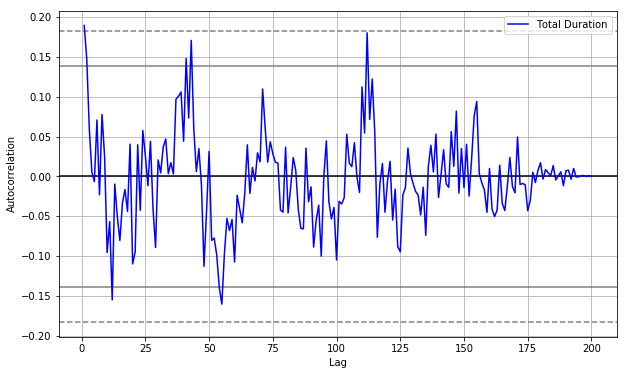

In [276]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(10,6))

lag = 200
autocorrelation_plot(y[len(y)-lag:], ax=ax, color='blue', label='Total Duration')
#autocorrelation_plot(y_oldprospect[len(y_oldprospect)-lag:], ax=ax, color='blue', label='Old Prospet Duration')
#autocorrelation_plot(y_newprospect[len(y_newprospect)-lag:], ax=ax, color='orange', label='New Prospect Duration')
#autocorrelation_plot(y_newlead[len(y_newlead)-lag:], ax=ax, color='darkgreen', label='New Lead Duration')

plt.legend()
pyplot.show()

In [209]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from math import sqrt

In [338]:
train, test = y[len(y)-200:len(y)-7], y[len(y)-7:]

In [339]:
model = AR(train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [340]:
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 14
Coefficients: const          276.724
L1.duration      0.197
L2.duration      0.117
L3.duration     -0.010
L4.duration     -0.010
L5.duration     -0.004
L6.duration      0.089
L7.duration     -0.095
L8.duration      0.100
L9.duration      0.031
L10.duration    -0.119
L11.duration    -0.011
L12.duration    -0.135
L13.duration     0.073
L14.duration    -0.047
dtype: float64


In [341]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) 
for i in range(len(predictions)):
    print('predicted=%i, expected=%i'%(predictions.iloc[i], test.iloc[i])) 
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=338, expected=281
predicted=334, expected=112
predicted=333, expected=334
predicted=366, expected=383
predicted=323, expected=189
predicted=370, expected=442
predicted=371, expected=239
Test RMSE: 115.771


/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


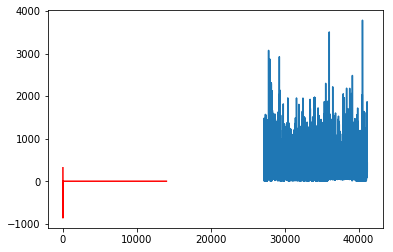

In [274]:
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red') 
pyplot.show()

In [251]:
from statsmodels.tsa.arima_model import ARIMA

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/paulde

                             ARIMA Model Results                              
Dep. Variable:             D.duration   No. Observations:                  199
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -554.333
Method:                       css-mle   S.D. of innovations              3.913
Date:                Mon, 14 Jan 2019   AIC                           1122.667
Time:                        02:21:08   BIC                           1145.720
Sample:                             1   HQIC                          1131.997
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0193      0.085     -0.227      0.821      -0.186       0.147
ar.L1.D.duration    -0.7523      0.069    -10.852      0.000      -0.888      -0.616
ar.L2.D.duration    -0.5700 

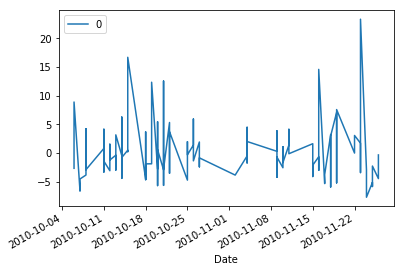

In [358]:
model = ARIMA(y_oldprospect[len(y_oldprospect)-lag:], order=(5,1,0))
model_fit = model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid) 
residuals.plot()
pyplot.show()

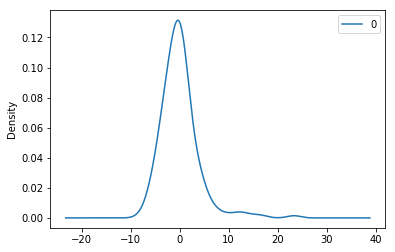

            0
count 199.000
mean    0.023
std     3.933
min    -7.725
25%    -2.360
50%    -0.388
75%     1.292
max    23.334


In [359]:
# density plot of residuals 
residuals.plot(kind='kde') 
pyplot.show()
# summary stats of residuals
print(residuals.describe())

In [360]:
size = int(len(y) * 0.80)
train, test = y[0:size], y[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test.iloc[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

predicted=332.919987, expected=65.000000
predicted=307.827322, expected=66.000000
predicted=296.980265, expected=34.000000
predicted=229.246262, expected=333.000000
predicted=252.391454, expected=128.000000
predicted=234.508157, expected=102.000000
predicted=122.351596, expected=400.000000
predicted=180.157773, expected=175.000000
predicted=194.788087, expected=69.000000
predicted=200.531177, expected=126.000000
predicted=166.853998, expected=285.000000
predicted=192.416820, expected=327.000000
predicted=230.462709, expected=168.000000
predicted=192.537115, expected=127.000000
predicted=184.423270, expected=314.000000
predicted=225.140037, expected=147.000000
predicted=226.217736, expected=472.000000
predicted=261.359550, expected=246.000000
predicted=246.400720, expected=213.000000
predicted=253.674157, expected=173.000000
predicted=260.473168, expected=220.000000
predicted=243.961746, expected=130.000000
predicted=240.204167, expected=299.000000
predicted=214.102765, expected=247.000

predicted=140.644805, expected=91.000000
predicted=140.592874, expected=52.000000
predicted=140.541703, expected=257.000000
predicted=164.361068, expected=99.000000
predicted=155.589596, expected=49.000000
predicted=93.647922, expected=882.000000
predicted=245.069607, expected=7.000000
predicted=222.444382, expected=515.000000
predicted=306.348500, expected=158.000000
predicted=285.547503, expected=259.000000
predicted=309.672493, expected=206.000000
predicted=335.720492, expected=25.000000
predicted=192.815805, expected=300.000000
predicted=243.430018, expected=246.000000
predicted=198.701610, expected=178.000000
predicted=202.080269, expected=318.000000
predicted=214.273896, expected=201.000000
predicted=211.513324, expected=105.000000
predicted=223.479271, expected=214.000000
predicted=210.391590, expected=67.000000
predicted=178.561033, expected=85.000000
predicted=163.551240, expected=82.000000
predicted=124.917500, expected=142.000000
predicted=115.414921, expected=187.000000
pre

predicted=400.641621, expected=184.000000
predicted=382.848291, expected=360.000000
predicted=408.074841, expected=165.000000
predicted=425.843804, expected=161.000000
predicted=373.147584, expected=84.000000
predicted=194.095362, expected=61.000000
predicted=167.107188, expected=267.000000
predicted=182.554463, expected=351.000000
predicted=182.607587, expected=183.000000
predicted=185.363110, expected=516.000000
predicted=247.993457, expected=393.000000
predicted=296.985270, expected=286.000000
predicted=333.008552, expected=87.000000
predicted=301.829892, expected=277.000000
predicted=289.503044, expected=200.000000
predicted=290.123100, expected=725.000000
predicted=330.747028, expected=204.000000
predicted=296.776922, expected=175.000000
predicted=279.435065, expected=247.000000
predicted=304.913853, expected=136.000000
predicted=277.522729, expected=218.000000
predicted=281.748360, expected=59.000000
predicted=172.036524, expected=146.000000
predicted=162.958858, expected=77.0000

predicted=215.293072, expected=464.000000
predicted=261.913853, expected=343.000000
predicted=268.380992, expected=98.000000
predicted=231.761694, expected=198.000000
predicted=230.504632, expected=361.000000
predicted=272.417408, expected=345.000000
predicted=300.411201, expected=114.000000
predicted=242.699857, expected=210.000000
predicted=222.059358, expected=556.000000
predicted=299.230916, expected=68.000000
predicted=272.799188, expected=239.000000
predicted=256.281257, expected=349.000000
predicted=257.577355, expected=112.000000
predicted=252.693289, expected=34.000000
predicted=224.363191, expected=181.000000
predicted=164.032236, expected=178.000000
predicted=180.422169, expected=206.000000
predicted=176.329226, expected=194.000000
predicted=152.170328, expected=209.000000
predicted=168.019000, expected=692.000000
predicted=280.958324, expected=210.000000
predicted=281.619984, expected=206.000000
predicted=287.368623, expected=355.000000
predicted=312.667364, expected=339.00

predicted=217.872683, expected=43.000000
predicted=215.922870, expected=240.000000
predicted=175.212839, expected=10.000000
predicted=156.437255, expected=17.000000
predicted=114.132395, expected=47.000000
predicted=117.283447, expected=296.000000
predicted=109.587168, expected=69.000000
predicted=112.726757, expected=323.000000
predicted=130.117369, expected=167.000000
predicted=154.438392, expected=570.000000
predicted=248.634770, expected=516.000000
predicted=326.523580, expected=220.000000
predicted=311.638496, expected=177.000000
predicted=329.103616, expected=388.000000
predicted=339.194752, expected=61.000000
predicted=317.216359, expected=585.000000
predicted=326.479715, expected=699.000000
predicted=358.969404, expected=133.000000
predicted=339.713990, expected=6.000000
predicted=311.648912, expected=96.000000
predicted=260.684539, expected=318.000000
predicted=301.913857, expected=413.000000
predicted=277.228072, expected=66.000000
predicted=172.617341, expected=590.000000
pr

predicted=129.553268, expected=38.000000
predicted=102.390612, expected=154.000000
predicted=104.584282, expected=148.000000
predicted=116.192830, expected=342.000000
predicted=149.148985, expected=43.000000
predicted=138.034537, expected=394.000000
predicted=189.510344, expected=68.000000
predicted=190.555266, expected=364.000000
predicted=227.658420, expected=125.000000
predicted=222.085055, expected=179.000000
predicted=195.154238, expected=427.000000
predicted=261.290042, expected=63.000000
predicted=202.628082, expected=197.000000
predicted=225.987613, expected=409.000000
predicted=235.418158, expected=299.000000
predicted=261.790445, expected=323.000000
predicted=287.551677, expected=215.000000
predicted=252.006689, expected=290.000000
predicted=288.646149, expected=147.000000
predicted=278.539149, expected=143.000000
predicted=234.684395, expected=541.000000
predicted=278.736815, expected=172.000000
predicted=250.234763, expected=309.000000
predicted=268.505716, expected=69.0000

predicted=150.864201, expected=65.000000
predicted=101.307641, expected=805.000000
predicted=224.697948, expected=97.000000
predicted=205.020356, expected=202.000000
predicted=231.722355, expected=777.000000
predicted=343.403405, expected=378.000000
predicted=385.811419, expected=654.000000
predicted=488.501438, expected=185.000000
predicted=382.601291, expected=1805.000000
predicted=679.445332, expected=367.000000
predicted=690.877598, expected=12.000000
predicted=565.911575, expected=139.000000
predicted=525.005741, expected=222.000000
predicted=445.916520, expected=122.000000
predicted=433.943484, expected=649.000000
predicted=256.301067, expected=168.000000
predicted=219.188408, expected=237.000000
predicted=257.886188, expected=135.000000
predicted=255.140843, expected=102.000000
predicted=232.560171, expected=65.000000
predicted=222.472344, expected=281.000000
predicted=165.210081, expected=80.000000
predicted=148.664076, expected=36.000000
predicted=116.178148, expected=143.0000

predicted=264.741613, expected=667.000000
predicted=286.051019, expected=136.000000
predicted=279.505700, expected=715.000000
predicted=358.928728, expected=123.000000
predicted=323.918322, expected=16.000000
predicted=313.612794, expected=414.000000
predicted=345.093321, expected=201.000000
predicted=263.865004, expected=212.000000
predicted=278.715152, expected=86.000000
predicted=175.804958, expected=317.000000
predicted=208.561942, expected=145.000000
predicted=227.042675, expected=532.000000
predicted=252.280847, expected=248.000000
predicted=257.285033, expected=158.000000
predicted=248.120996, expected=141.000000
predicted=256.207255, expected=190.000000
predicted=233.723654, expected=161.000000
predicted=235.746308, expected=23.000000
predicted=151.841652, expected=276.000000
predicted=159.522066, expected=7.000000
predicted=130.936369, expected=201.000000
predicted=143.711535, expected=20.000000
predicted=113.690852, expected=51.000000
predicted=95.553456, expected=467.000000


predicted=264.644170, expected=202.000000
predicted=291.419467, expected=112.000000
predicted=289.891789, expected=154.000000
predicted=295.030705, expected=337.000000
predicted=325.520662, expected=1723.000000
predicted=460.060346, expected=177.000000
predicted=449.650467, expected=95.000000
predicted=437.600900, expected=246.000000
predicted=455.390495, expected=294.000000
predicted=470.293569, expected=162.000000
predicted=441.292744, expected=406.000000
predicted=232.918765, expected=20.000000
predicted=202.102194, expected=115.000000
predicted=206.517958, expected=543.000000
predicted=259.042992, expected=73.000000
predicted=217.023967, expected=136.000000
predicted=216.081052, expected=138.000000
predicted=171.360905, expected=118.000000
predicted=184.881187, expected=30.000000
predicted=170.266200, expected=444.000000
predicted=159.699897, expected=466.000000
predicted=224.221466, expected=110.000000
predicted=218.023454, expected=97.000000
predicted=212.219235, expected=7.00000

predicted=488.583076, expected=134.000000
predicted=473.477390, expected=353.000000
predicted=495.290008, expected=72.000000
predicted=406.838381, expected=337.000000
predicted=412.769778, expected=93.000000
predicted=319.556279, expected=291.000000
predicted=214.238779, expected=546.000000
predicted=284.372066, expected=252.000000
predicted=265.662389, expected=532.000000
predicted=345.645176, expected=204.000000
predicted=319.507901, expected=152.000000
predicted=327.837139, expected=267.000000
predicted=323.828560, expected=406.000000
predicted=301.665776, expected=1094.000000
predicted=448.596457, expected=320.000000
predicted=408.449307, expected=884.000000
predicted=529.064168, expected=410.000000
predicted=563.282263, expected=210.000000
predicted=550.332441, expected=198.000000
predicted=514.249554, expected=241.000000
predicted=373.086800, expected=16.000000
predicted=320.129624, expected=460.000000
predicted=257.181650, expected=604.000000
predicted=290.863249, expected=427.0

predicted=338.289053, expected=21.000000
predicted=307.600588, expected=128.000000
predicted=296.478527, expected=146.000000
predicted=266.705281, expected=71.000000
predicted=226.211812, expected=169.000000
predicted=213.582496, expected=302.000000
predicted=141.367555, expected=198.000000
predicted=169.637912, expected=302.000000
predicted=200.238366, expected=6.000000
predicted=173.689614, expected=64.000000
predicted=172.252328, expected=49.000000
predicted=151.002396, expected=242.000000
predicted=143.081379, expected=124.000000
predicted=130.696830, expected=20.000000
predicted=84.612652, expected=1452.000000
predicted=337.409162, expected=317.000000
predicted=368.159525, expected=95.000000
predicted=378.437884, expected=16.000000
predicted=336.540771, expected=67.000000
predicted=320.318740, expected=241.000000
predicted=357.568083, expected=250.000000
predicted=164.497752, expected=7.000000
predicted=112.747927, expected=432.000000
predicted=172.727103, expected=153.000000
pred

predicted=320.493577, expected=663.000000
predicted=393.339070, expected=210.000000
predicted=397.316142, expected=119.000000
predicted=385.412087, expected=133.000000
predicted=383.566296, expected=18.000000
predicted=217.793460, expected=8.000000
predicted=187.486721, expected=261.000000
predicted=125.340374, expected=81.000000
predicted=102.755459, expected=65.000000
predicted=94.863303, expected=437.000000
predicted=148.830310, expected=102.000000
predicted=158.547647, expected=217.000000
predicted=195.163254, expected=63.000000
predicted=160.476004, expected=562.000000
predicted=243.646761, expected=74.000000
predicted=240.518186, expected=189.000000
predicted=202.526826, expected=212.000000
predicted=219.640738, expected=500.000000
predicted=267.982706, expected=172.000000
predicted=283.700168, expected=20.000000
predicted=194.344781, expected=327.000000
predicted=237.369181, expected=16.000000
predicted=203.831889, expected=894.000000
predicted=326.898127, expected=152.000000
pr

predicted=134.418308, expected=167.000000
predicted=127.463357, expected=113.000000
predicted=120.295783, expected=1002.000000
predicted=257.383223, expected=48.000000
predicted=246.795473, expected=54.000000
predicted=241.274699, expected=306.000000
predicted=282.836597, expected=61.000000
predicted=257.600396, expected=20.000000
predicted=244.112152, expected=16.000000
predicted=83.864820, expected=880.000000
predicted=228.368083, expected=69.000000
predicted=223.675471, expected=218.000000
predicted=215.069535, expected=18.000000
predicted=203.625237, expected=47.000000
predicted=203.371306, expected=333.000000
predicted=258.672591, expected=102.000000
predicted=130.336918, expected=64.000000
predicted=130.683146, expected=101.000000
predicted=111.620927, expected=800.000000
predicted=245.960952, expected=131.000000
predicted=253.946201, expected=476.000000
predicted=284.828992, expected=65.000000
predicted=272.756253, expected=262.000000
predicted=304.003509, expected=934.000000
pr

predicted=163.030570, expected=15.000000
predicted=137.315176, expected=216.000000
predicted=121.607913, expected=170.000000
predicted=122.675055, expected=288.000000
predicted=145.552012, expected=17.000000
predicted=130.242353, expected=220.000000
predicted=156.015417, expected=28.000000
predicted=154.305164, expected=169.000000
predicted=148.164304, expected=185.000000
predicted=151.010601, expected=88.000000
predicted=117.584724, expected=903.000000
predicted=272.383571, expected=248.000000
predicted=270.506100, expected=12.000000
predicted=269.656428, expected=52.000000
predicted=248.298013, expected=155.000000
predicted=237.641235, expected=205.000000
predicted=257.577207, expected=68.000000
predicted=122.991259, expected=63.000000
predicted=93.575152, expected=114.000000
predicted=109.403237, expected=297.000000
predicted=150.712165, expected=185.000000
predicted=155.515425, expected=186.000000
predicted=154.192600, expected=222.000000
predicted=179.342112, expected=284.000000
p

predicted=144.082445, expected=227.000000
predicted=183.640075, expected=375.000000
predicted=242.374232, expected=241.000000
predicted=276.465671, expected=190.000000
predicted=281.936036, expected=213.000000
predicted=214.277261, expected=412.000000
predicted=276.818097, expected=31.000000
predicted=240.863917, expected=173.000000
predicted=210.749059, expected=74.000000
predicted=180.464896, expected=92.000000
predicted=163.577299, expected=166.000000
predicted=157.125390, expected=368.000000
predicted=152.671259, expected=1027.000000
predicted=324.046587, expected=221.000000
predicted=325.933414, expected=113.000000
predicted=334.887997, expected=577.000000
predicted=414.723317, expected=567.000000
predicted=475.075888, expected=12.000000
predicted=414.396491, expected=428.000000
predicted=324.002049, expected=767.000000
predicted=412.489435, expected=142.000000
predicted=410.851546, expected=68.000000
predicted=331.489955, expected=61.000000
predicted=245.006894, expected=695.0000

predicted=360.726831, expected=354.000000
predicted=315.202526, expected=112.000000
predicted=316.261611, expected=101.000000
predicted=280.774697, expected=174.000000
predicted=278.211115, expected=128.000000
predicted=203.052491, expected=283.000000
predicted=192.692548, expected=421.000000
predicted=205.743090, expected=119.000000
predicted=204.172552, expected=70.000000
predicted=199.492789, expected=91.000000
predicted=183.972457, expected=109.000000
predicted=179.336884, expected=64.000000
predicted=143.801332, expected=104.000000
predicted=93.058069, expected=397.000000
predicted=141.850270, expected=327.000000
predicted=183.552447, expected=106.000000
predicted=185.459833, expected=90.000000
predicted=182.081331, expected=296.000000
predicted=219.816127, expected=179.000000
predicted=230.137709, expected=69.000000
predicted=177.141424, expected=112.000000
predicted=142.402872, expected=265.000000
predicted=168.615032, expected=54.000000
predicted=160.522518, expected=344.000000

predicted=176.290397, expected=264.000000
predicted=207.052571, expected=94.000000
predicted=197.392809, expected=258.000000
predicted=218.251844, expected=137.000000
predicted=179.866714, expected=189.000000
predicted=176.896625, expected=245.000000
predicted=198.348454, expected=253.000000
predicted=196.453994, expected=752.000000
predicted=310.679715, expected=185.000000
predicted=292.956520, expected=129.000000
predicted=293.389077, expected=175.000000
predicted=288.821973, expected=480.000000
predicted=327.681243, expected=532.000000
predicted=375.734690, expected=229.000000
predicted=289.562066, expected=163.000000
predicted=285.791571, expected=71.000000
predicted=272.283917, expected=161.000000
predicted=269.296949, expected=82.000000
predicted=203.414903, expected=121.000000
predicted=137.379510, expected=439.000000
predicted=175.543058, expected=193.000000
predicted=177.896343, expected=242.000000
predicted=208.499605, expected=188.000000
predicted=211.423168, expected=282.00

predicted=253.086718, expected=232.000000
predicted=277.350599, expected=284.000000
predicted=297.822784, expected=253.000000
predicted=257.220573, expected=352.000000
predicted=298.141968, expected=470.000000
predicted=303.072506, expected=1144.000000
predicted=463.873360, expected=336.000000
predicted=472.956035, expected=195.000000
predicted=460.077688, expected=373.000000
predicted=477.610709, expected=78.000000
predicted=424.173977, expected=89.000000
predicted=364.363401, expected=134.000000
predicted=199.351114, expected=181.000000
predicted=173.539061, expected=55.000000
predicted=150.259320, expected=187.000000
predicted=121.968585, expected=113.000000
predicted=126.075958, expected=314.000000
predicted=165.635111, expected=206.000000
predicted=176.545694, expected=288.000000
predicted=195.768432, expected=93.000000
predicted=199.578889, expected=327.000000
predicted=224.801350, expected=163.000000
predicted=230.337155, expected=111.000000
predicted=197.174335, expected=149.00

predicted=263.987176, expected=37.000000
predicted=214.499996, expected=593.000000
predicted=270.306451, expected=101.000000
predicted=265.128829, expected=302.000000
predicted=283.781948, expected=138.000000
predicted=262.552179, expected=165.000000
predicted=221.061890, expected=88.000000
predicted=228.995729, expected=116.000000
predicted=150.760078, expected=340.000000
predicted=192.479033, expected=95.000000
predicted=156.018406, expected=591.000000
predicted=237.599880, expected=88.000000
predicted=218.502939, expected=90.000000
predicted=220.200041, expected=385.000000
predicted=266.145295, expected=2219.000000
predicted=593.356420, expected=240.000000
predicted=598.634746, expected=174.000000
predicted=541.089228, expected=467.000000
predicted=597.475499, expected=107.000000
predicted=583.734231, expected=238.000000
predicted=567.912961, expected=95.000000
predicted=218.713241, expected=170.000000
predicted=206.984972, expected=342.000000
predicted=236.932550, expected=113.0000

predicted=253.763498, expected=153.000000
predicted=250.341698, expected=522.000000
predicted=315.713593, expected=76.000000
predicted=304.890932, expected=227.000000
predicted=298.390907, expected=471.000000
predicted=342.366376, expected=92.000000
predicted=253.816250, expected=329.000000
predicted=287.885376, expected=207.000000
predicted=233.333307, expected=263.000000
predicted=264.175968, expected=57.000000
predicted=234.530455, expected=577.000000
predicted=257.687273, expected=271.000000
predicted=282.754056, expected=455.000000
predicted=308.289442, expected=103.000000
predicted=287.090101, expected=333.000000
predicted=299.980594, expected=366.000000
predicted=349.459246, expected=201.000000
predicted=286.588242, expected=166.000000
predicted=270.422661, expected=89.000000
predicted=208.300024, expected=58.000000
predicted=199.350728, expected=548.000000
predicted=240.135919, expected=95.000000
predicted=190.998694, expected=96.000000
predicted=176.875091, expected=438.000000

predicted=682.353450, expected=133.000000
predicted=625.165372, expected=259.000000
predicted=612.345081, expected=280.000000
predicted=516.489748, expected=112.000000
predicted=511.893793, expected=63.000000
predicted=401.365328, expected=293.000000
predicted=190.594579, expected=474.000000
predicted=247.855002, expected=241.000000
predicted=244.384186, expected=140.000000
predicted=222.237867, expected=177.000000
predicted=231.330338, expected=295.000000
predicted=268.491941, expected=457.000000
predicted=297.869671, expected=177.000000
predicted=247.792138, expected=100.000000
predicted=224.904323, expected=136.000000
predicted=222.558227, expected=111.000000
predicted=209.541216, expected=271.000000
predicted=208.154117, expected=67.000000
predicted=142.747022, expected=883.000000
predicted=268.856469, expected=115.000000
predicted=262.298545, expected=269.000000
predicted=289.584214, expected=570.000000
predicted=365.463158, expected=238.000000
predicted=353.554220, expected=524.0

predicted=231.788336, expected=58.000000
predicted=219.222033, expected=125.000000
predicted=185.303941, expected=91.000000
predicted=145.806232, expected=258.000000
predicted=154.620780, expected=305.000000
predicted=168.745964, expected=465.000000
predicted=220.793870, expected=1084.000000
predicted=397.397438, expected=106.000000
predicted=383.805388, expected=64.000000
predicted=381.497660, expected=139.000000
predicted=356.800076, expected=116.000000
predicted=321.153252, expected=506.000000
predicted=335.248384, expected=195.000000
predicted=188.185165, expected=82.000000
predicted=184.837677, expected=105.000000
predicted=190.241054, expected=332.000000
predicted=222.124206, expected=132.000000
predicted=222.851527, expected=73.000000
predicted=153.417127, expected=822.000000
predicted=264.454645, expected=51.000000
predicted=249.395928, expected=148.000000
predicted=261.784470, expected=72.000000
predicted=215.105200, expected=67.000000
predicted=201.161385, expected=99.000000


predicted=203.709662, expected=187.000000
predicted=222.495061, expected=161.000000
predicted=225.313401, expected=489.000000
predicted=279.985170, expected=120.000000
predicted=274.234053, expected=158.000000
predicted=211.430858, expected=246.000000
predicted=227.149423, expected=252.000000
predicted=236.353493, expected=156.000000
predicted=235.609253, expected=1529.000000
predicted=423.274826, expected=235.000000
predicted=427.449717, expected=155.000000
predicted=433.273653, expected=155.000000
predicted=412.834359, expected=289.000000
predicted=412.504873, expected=153.000000
predicted=412.070404, expected=352.000000
predicted=225.133586, expected=411.000000
predicted=254.481532, expected=107.000000
predicted=243.614959, expected=89.000000
predicted=233.256642, expected=85.000000
predicted=197.391151, expected=151.000000
predicted=196.434067, expected=96.000000
predicted=154.791455, expected=540.000000
predicted=182.288861, expected=263.000000
predicted=204.927923, expected=247.0

predicted=257.363491, expected=485.000000
predicted=305.975706, expected=282.000000
predicted=284.198267, expected=307.000000
predicted=284.223498, expected=399.000000
predicted=333.277195, expected=164.000000
predicted=295.913261, expected=791.000000
predicted=409.192126, expected=1152.000000
predicted=522.417276, expected=138.000000
predicted=490.014297, expected=138.000000
predicted=466.261297, expected=328.000000
predicted=449.002409, expected=72.000000
predicted=425.921944, expected=136.000000
predicted=323.514784, expected=192.000000
predicted=167.495052, expected=78.000000
predicted=155.421385, expected=347.000000
predicted=194.049745, expected=464.000000
predicted=217.570312, expected=189.000000
predicted=234.703128, expected=160.000000
predicted=239.845967, expected=293.000000
predicted=255.596839, expected=233.000000
predicted=278.544838, expected=105.000000
predicted=238.928438, expected=227.000000
predicted=202.031198, expected=100.000000
predicted=184.487158, expected=57.0

predicted=320.917229, expected=431.000000
predicted=344.324732, expected=220.000000
predicted=327.436271, expected=536.000000
predicted=386.086670, expected=206.000000
predicted=368.631055, expected=578.000000
predicted=397.071219, expected=250.000000
predicted=368.549224, expected=207.000000
predicted=332.140452, expected=65.000000
predicted=304.070488, expected=238.000000
predicted=255.456844, expected=768.000000
predicted=353.641079, expected=225.000000
predicted=291.295597, expected=89.000000
predicted=267.451446, expected=98.000000
predicted=246.584261, expected=240.000000
predicted=272.608997, expected=173.000000
predicted=261.953585, expected=164.000000
predicted=165.356488, expected=170.000000
predicted=156.489737, expected=232.000000
predicted=179.950396, expected=67.000000
predicted=172.873607, expected=76.000000
predicted=146.584187, expected=145.000000
predicted=141.827054, expected=328.000000
predicted=170.474163, expected=195.000000
predicted=174.074575, expected=484.0000

predicted=109.196620, expected=160.000000
predicted=125.565120, expected=473.000000
predicted=194.514008, expected=62.000000
predicted=183.072135, expected=114.000000
predicted=186.025060, expected=83.000000
predicted=156.975547, expected=186.000000
predicted=177.898098, expected=121.000000
predicted=171.491201, expected=81.000000
predicted=108.082144, expected=267.000000
predicted=143.688566, expected=106.000000
predicted=139.851805, expected=470.000000
predicted=208.789994, expected=98.000000
predicted=189.767287, expected=271.000000
predicted=217.732783, expected=139.000000
predicted=224.162693, expected=79.000000
predicted=191.915823, expected=89.000000
predicted=189.169259, expected=197.000000
predicted=145.231377, expected=81.000000
predicted=141.160217, expected=69.000000
predicted=109.095883, expected=97.000000
predicted=102.059625, expected=265.000000
predicted=133.855397, expected=157.000000
predicted=144.197285, expected=28.000000
predicted=116.388100, expected=513.000000
pr

predicted=264.110430, expected=85.000000
predicted=170.318276, expected=394.000000
predicted=190.003418, expected=161.000000
predicted=189.100751, expected=170.000000
predicted=166.657832, expected=722.000000
predicted=273.605311, expected=150.000000
predicted=278.340353, expected=458.000000
predicted=346.543389, expected=133.000000
predicted=297.893911, expected=1962.000000
predicted=612.664869, expected=107.000000
predicted=583.144807, expected=173.000000
predicted=503.606067, expected=89.000000
predicted=484.622558, expected=875.000000
predicted=551.285642, expected=208.000000
predicted=559.722070, expected=126.000000
predicted=265.898444, expected=91.000000
predicted=260.571221, expected=106.000000
predicted=244.337617, expected=103.000000
predicted=246.819278, expected=925.000000
predicted=266.220268, expected=39.000000
predicted=229.925316, expected=109.000000
predicted=232.515380, expected=188.000000
predicted=245.592227, expected=111.000000
predicted=240.385278, expected=153.00

predicted=504.679405, expected=49.000000
predicted=439.262835, expected=182.000000
predicted=456.507886, expected=213.000000
predicted=287.802888, expected=285.000000
predicted=297.335313, expected=200.000000
predicted=193.532927, expected=169.000000
predicted=183.948527, expected=221.000000
predicted=211.907652, expected=210.000000
predicted=215.610980, expected=75.000000
predicted=191.780932, expected=404.000000
predicted=215.487493, expected=1573.000000
predicted=454.316176, expected=896.000000
predicted=568.813256, expected=301.000000
predicted=582.750626, expected=204.000000
predicted=577.440817, expected=1003.000000
predicted=727.839016, expected=115.000000
predicted=668.068389, expected=82.000000
predicted=431.239751, expected=123.000000
predicted=303.480432, expected=120.000000
predicted=267.493246, expected=216.000000
predicted=272.675148, expected=84.000000
predicted=123.146619, expected=958.000000
predicted=272.620116, expected=146.000000
predicted=273.540335, expected=237.0

predicted=348.069554, expected=91.000000
predicted=292.152307, expected=76.000000
predicted=201.489335, expected=292.000000
predicted=207.344831, expected=281.000000
predicted=182.785445, expected=93.000000
predicted=161.518401, expected=131.000000
predicted=162.127496, expected=257.000000
predicted=188.548797, expected=56.000000
predicted=181.979261, expected=61.000000
predicted=145.839170, expected=183.000000
predicted=130.648004, expected=87.000000
predicted=127.356341, expected=633.000000
predicted=217.814327, expected=127.000000
predicted=191.401624, expected=110.000000
predicted=202.425851, expected=151.000000
predicted=215.473914, expected=99.000000
predicted=197.226442, expected=87.000000
predicted=197.750210, expected=251.000000
predicted=138.753077, expected=67.000000
predicted=126.498302, expected=703.000000
predicted=232.684974, expected=126.000000
predicted=221.789641, expected=355.000000
predicted=269.137413, expected=298.000000
predicted=301.239093, expected=156.000000
p

predicted=277.953934, expected=284.000000
predicted=293.322677, expected=383.000000
predicted=323.157214, expected=258.000000
predicted=304.807175, expected=90.000000
predicted=287.396349, expected=116.000000
predicted=253.173901, expected=298.000000
predicted=236.726376, expected=70.000000
predicted=199.123855, expected=138.000000
predicted=162.052664, expected=101.000000
predicted=135.331638, expected=85.000000
predicted=133.126762, expected=158.000000
predicted=141.150119, expected=358.000000
predicted=153.901377, expected=199.000000
predicted=173.939809, expected=112.000000
predicted=170.268107, expected=156.000000
predicted=178.749250, expected=272.000000
predicted=208.552208, expected=572.000000
predicted=280.365418, expected=88.000000
predicted=232.843255, expected=257.000000
predicted=246.207467, expected=96.000000
predicted=238.469092, expected=143.000000
predicted=234.569361, expected=749.000000
predicted=320.593755, expected=111.000000
predicted=239.458990, expected=509.0000

predicted=143.333135, expected=843.000000
predicted=260.489757, expected=365.000000
predicted=293.776202, expected=62.000000
predicted=275.916415, expected=107.000000
predicted=272.216267, expected=235.000000
predicted=278.544330, expected=432.000000
predicted=336.797522, expected=244.000000
predicted=241.106769, expected=136.000000
predicted=204.770322, expected=137.000000
predicted=215.356151, expected=175.000000
predicted=224.108132, expected=104.000000
predicted=201.600750, expected=250.000000
predicted=174.869038, expected=986.000000
predicted=305.606285, expected=57.000000
predicted=283.777378, expected=643.000000
predicted=377.928171, expected=175.000000
predicted=368.819152, expected=79.000000
predicted=359.890720, expected=93.000000
predicted=334.001065, expected=94.000000
predicted=186.364610, expected=380.000000
predicted=242.379813, expected=381.000000
predicted=202.374240, expected=446.000000
predicted=250.026032, expected=104.000000
predicted=251.089480, expected=69.00000

predicted=317.006161, expected=72.000000
predicted=274.416589, expected=314.000000
predicted=269.014435, expected=325.000000
predicted=296.509640, expected=205.000000
predicted=252.427469, expected=354.000000
predicted=260.857742, expected=546.000000
predicted=305.786197, expected=155.000000
predicted=314.994892, expected=97.000000
predicted=280.181007, expected=103.000000
predicted=241.198748, expected=141.000000
predicted=228.108403, expected=412.000000
predicted=242.166258, expected=330.000000
predicted=208.228836, expected=110.000000
predicted=200.190070, expected=726.000000
predicted=310.260514, expected=324.000000
predicted=339.840064, expected=184.000000
predicted=347.490266, expected=170.000000
predicted=307.728544, expected=454.000000
predicted=326.840578, expected=379.000000
predicted=370.192926, expected=406.000000
predicted=321.830445, expected=248.000000
predicted=308.409021, expected=127.000000
predicted=295.830906, expected=415.000000
predicted=337.618695, expected=52.00

predicted=221.061540, expected=93.000000
predicted=211.593587, expected=184.000000
predicted=140.811083, expected=335.000000
predicted=180.783214, expected=257.000000
predicted=180.891358, expected=228.000000
predicted=206.329561, expected=282.000000
predicted=231.613502, expected=117.000000
predicted=232.168954, expected=275.000000
predicted=248.924513, expected=171.000000
predicted=220.502772, expected=169.000000
predicted=206.191233, expected=102.000000
predicted=185.196801, expected=121.000000
predicted=158.211426, expected=290.000000
predicted=188.301658, expected=422.000000
predicted=214.577568, expected=119.000000
predicted=204.172898, expected=215.000000
predicted=213.809254, expected=212.000000
predicted=229.452284, expected=229.000000
predicted=245.889439, expected=213.000000
predicted=234.554796, expected=104.000000
predicted=181.537582, expected=144.000000
predicted=185.584100, expected=209.000000
predicted=184.607910, expected=261.000000
predicted=193.365890, expected=106.

predicted=377.169758, expected=143.000000
predicted=368.343299, expected=176.000000
predicted=359.524832, expected=176.000000
predicted=361.027316, expected=113.000000
predicted=344.008015, expected=295.000000
predicted=378.123248, expected=232.000000
predicted=189.540843, expected=218.000000
predicted=202.460410, expected=240.000000
predicted=213.710336, expected=278.000000
predicted=229.867197, expected=398.000000
predicted=278.071152, expected=173.000000
predicted=256.121779, expected=220.000000
predicted=255.139809, expected=185.000000
predicted=248.019709, expected=200.000000
predicted=240.401346, expected=200.000000
predicted=228.405922, expected=141.000000
predicted=185.915544, expected=330.000000
predicted=213.963347, expected=214.000000
predicted=211.550283, expected=191.000000
predicted=213.052572, expected=98.000000
predicted=195.303740, expected=699.000000
predicted=282.932555, expected=218.000000
predicted=290.244155, expected=177.000000
predicted=267.872403, expected=961.

predicted=323.229947, expected=801.000000
predicted=365.814006, expected=193.000000
predicted=308.135786, expected=309.000000
predicted=285.821504, expected=176.000000
predicted=292.282672, expected=152.000000
predicted=295.739872, expected=171.000000
predicted=296.868385, expected=333.000000
predicted=222.539573, expected=228.000000
predicted=227.736536, expected=317.000000
predicted=231.673597, expected=236.000000
predicted=240.464265, expected=208.000000
predicted=248.468151, expected=248.000000
predicted=261.412386, expected=144.000000
predicted=228.532405, expected=762.000000
predicted=323.849979, expected=360.000000
predicted=326.842906, expected=372.000000
predicted=352.454461, expected=177.000000
predicted=344.823488, expected=267.000000
predicted=344.216294, expected=18.000000
predicted=319.879074, expected=414.000000
predicted=268.190100, expected=271.000000
predicted=252.169238, expected=289.000000
predicted=240.454883, expected=400.000000
predicted=279.956535, expected=306.

predicted=139.624215, expected=712.000000
predicted=253.748064, expected=118.000000
predicted=261.354716, expected=294.000000
predicted=283.483822, expected=874.000000
predicted=399.125635, expected=479.000000
predicted=445.368277, expected=722.000000
predicted=538.800262, expected=192.000000
predicted=447.071749, expected=46.000000
predicted=429.308991, expected=138.000000
predicted=402.398294, expected=135.000000
predicted=278.393889, expected=602.000000
predicted=306.886614, expected=141.000000
predicted=208.978690, expected=278.000000
predicted=227.085744, expected=422.000000
predicted=288.953286, expected=434.000000
predicted=334.876502, expected=187.000000
predicted=342.856638, expected=245.000000
predicted=285.710404, expected=661.000000
predicted=373.611411, expected=270.000000
predicted=367.140757, expected=168.000000
predicted=327.831434, expected=212.000000
predicted=290.883938, expected=458.000000
predicted=334.206743, expected=713.000000
predicted=415.497835, expected=614.

predicted=446.840102, expected=179.000000
predicted=404.836667, expected=667.000000
predicted=497.975890, expected=129.000000
predicted=474.012762, expected=194.000000
predicted=372.219238, expected=9.000000
predicted=258.622684, expected=101.000000
predicted=208.556762, expected=251.000000
predicted=222.845208, expected=29.000000
predicted=116.962255, expected=17.000000
predicted=100.263257, expected=128.000000
predicted=89.814400, expected=175.000000
predicted=115.896701, expected=140.000000
predicted=123.436827, expected=182.000000
predicted=114.052429, expected=255.000000
predicted=151.446535, expected=209.000000
predicted=182.038902, expected=267.000000
predicted=206.205259, expected=335.000000
predicted=233.200670, expected=212.000000
predicted=243.262095, expected=257.000000
predicted=256.635772, expected=319.000000
predicted=267.172484, expected=42.000000
predicted=235.707853, expected=396.000000
predicted=261.984060, expected=386.000000
predicted=269.181584, expected=667.00000

predicted=200.517605, expected=355.000000
predicted=245.697993, expected=115.000000
predicted=209.517977, expected=942.000000
predicted=319.836032, expected=355.000000
predicted=349.068766, expected=1193.000000
predicted=506.978866, expected=368.000000
predicted=556.309243, expected=138.000000
predicted=516.293807, expected=321.000000
predicted=550.138800, expected=248.000000
predicted=427.943725, expected=23.000000
predicted=373.917470, expected=24.000000
predicted=185.308160, expected=174.000000
predicted=153.066238, expected=860.000000
predicted=279.830080, expected=427.000000
predicted=295.374636, expected=171.000000
predicted=284.707232, expected=608.000000
predicted=383.988872, expected=351.000000
predicted=427.282146, expected=366.000000
predicted=461.748247, expected=350.000000
predicted=380.080470, expected=125.000000
predicted=324.996832, expected=192.000000
predicted=329.265705, expected=513.000000
predicted=316.842019, expected=251.000000
predicted=297.421335, expected=196.

predicted=254.182954, expected=178.000000
predicted=236.460602, expected=174.000000
predicted=239.886085, expected=160.000000
predicted=254.382958, expected=252.000000
predicted=255.567691, expected=366.000000
predicted=226.212591, expected=177.000000
predicted=218.016041, expected=101.000000
predicted=205.284303, expected=744.000000
predicted=305.390296, expected=245.000000
predicted=311.936937, expected=239.000000
predicted=314.067546, expected=6.000000
predicted=251.482842, expected=148.000000
predicted=242.846886, expected=6.000000
predicted=225.083127, expected=370.000000
predicted=169.974347, expected=440.000000
predicted=204.367674, expected=145.000000
predicted=187.260503, expected=362.000000
predicted=250.030733, expected=182.000000
predicted=249.984302, expected=195.000000
predicted=279.958011, expected=361.000000
predicted=281.620846, expected=265.000000
predicted=251.049367, expected=324.000000
predicted=282.687086, expected=1087.000000
predicted=411.809432, expected=242.00

predicted=368.545591, expected=194.000000
predicted=360.150103, expected=369.000000
predicted=335.290408, expected=36.000000
predicted=202.179811, expected=255.000000
predicted=184.816308, expected=145.000000
predicted=183.897604, expected=127.000000
predicted=185.738077, expected=198.000000
predicted=188.774756, expected=11.000000
predicted=126.738303, expected=136.000000
predicted=145.038344, expected=113.000000
predicted=120.964982, expected=415.000000
predicted=169.046125, expected=908.000000
predicted=305.243557, expected=250.000000
predicted=307.666911, expected=35.000000
predicted=311.577648, expected=125.000000
predicted=305.839552, expected=213.000000
predicted=316.835638, expected=8.000000
predicted=250.447670, expected=164.000000
predicted=133.534483, expected=202.000000
predicted=125.224829, expected=791.000000
predicted=256.731859, expected=272.000000
predicted=276.806641, expected=667.000000
predicted=358.973870, expected=728.000000
predicted=476.233707, expected=314.0000

predicted=285.751605, expected=245.000000
predicted=253.270592, expected=272.000000
predicted=279.368188, expected=134.000000
predicted=234.731845, expected=133.000000
predicted=222.207469, expected=173.000000
predicted=183.957980, expected=157.000000
predicted=184.139754, expected=349.000000
predicted=204.665630, expected=232.000000
predicted=197.229197, expected=224.000000
predicted=212.614484, expected=246.000000
predicted=231.300393, expected=249.000000
predicted=242.361509, expected=395.000000
predicted=283.650635, expected=732.000000
predicted=351.533378, expected=618.000000
predicted=414.706459, expected=19.000000
predicted=375.482456, expected=6.000000
predicted=334.518696, expected=262.000000
predicted=333.702365, expected=157.000000
predicted=291.570738, expected=188.000000
predicted=207.812186, expected=169.000000
predicted=135.587743, expected=132.000000
predicted=152.032261, expected=290.000000
predicted=200.630090, expected=156.000000
predicted=181.495328, expected=379.00

predicted=290.160970, expected=262.000000
predicted=281.405192, expected=1032.000000
predicted=436.316456, expected=759.000000
predicted=490.304739, expected=549.000000
predicted=544.089287, expected=201.000000
predicted=498.225623, expected=330.000000
predicted=517.171486, expected=212.000000
predicted=504.595865, expected=256.000000
predicted=379.428693, expected=339.000000
predicted=314.225188, expected=738.000000
predicted=351.076904, expected=394.000000
predicted=379.847219, expected=716.000000
predicted=449.439906, expected=234.000000
predicted=445.571400, expected=168.000000
predicted=427.224721, expected=380.000000
predicted=435.955822, expected=84.000000
predicted=322.252647, expected=142.000000
predicted=284.181599, expected=554.000000
predicted=264.122767, expected=344.000000
predicted=278.588136, expected=608.000000
predicted=357.782215, expected=92.000000
predicted=304.290561, expected=83.000000
predicted=300.965040, expected=225.000000
predicted=314.503602, expected=189.0

Test RMSE: 268.870


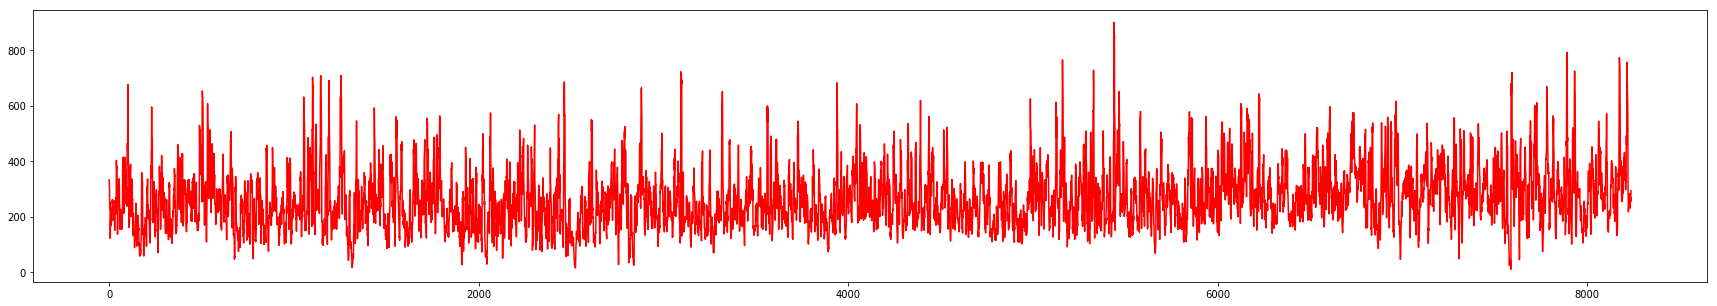

In [365]:
plt.figure(figsize=(30,5))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes pyplot.plot(test)
pyplot.plot(predictions, color='red') 
pyplot.show()

In [371]:
!pwd

/Users/pauldefusco/Documents/PythonWork/machine_learning_projects/marketing_campaign_prediction/iteration_1


In [375]:
from __future__ import division
#Let's try dividing duration by 60 to predict minutes:
final_df = pd.read_pickle('../../../../mkt_camp_data/final_df_pickle.pickle')
##Old Prospect
oldp_idx = final_df[final_df['old_prospect']==1].index
y_oldprospect = y[oldp_idx]/60
y_oldprospect.index = final_df[final_df['old_prospect']==1].Date
##New Prospect
newp_idx = final_df[final_df['new_prospect']==1].index
y_newprospect = y[newp_idx]/60
y_newprospect.index = final_df[final_df['new_prospect']==1].Date
##New Lead
newl_idx = final_df[final_df['new_lead']==1].index
y_newlead = y[newl_idx]/60
y_newlead.index = final_df[final_df['new_lead']==1].Date

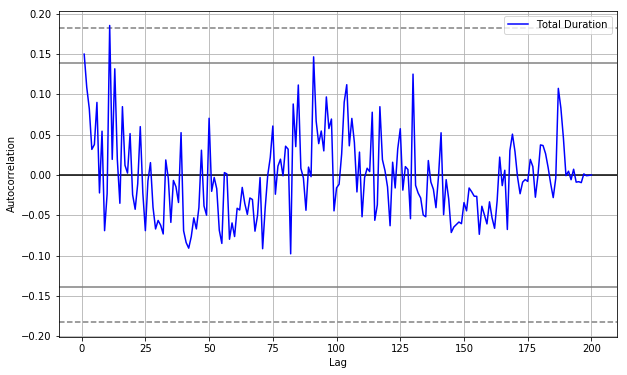

In [376]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(10,6))

lag = 200
autocorrelation_plot(y_oldprospect[len(y_oldprospect)-lag:], ax=ax, color='blue', label='Total Duration')
#autocorrelation_plot(y_oldprospect[len(y_oldprospect)-lag:], ax=ax, color='blue', label='Old Prospet Duration')
#autocorrelation_plot(y_newprospect[len(y_newprospect)-lag:], ax=ax, color='orange', label='New Prospect Duration')
#autocorrelation_plot(y_newlead[len(y_newlead)-lag:], ax=ax, color='darkgreen', label='New Lead Duration')

plt.legend()
pyplot.show()

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


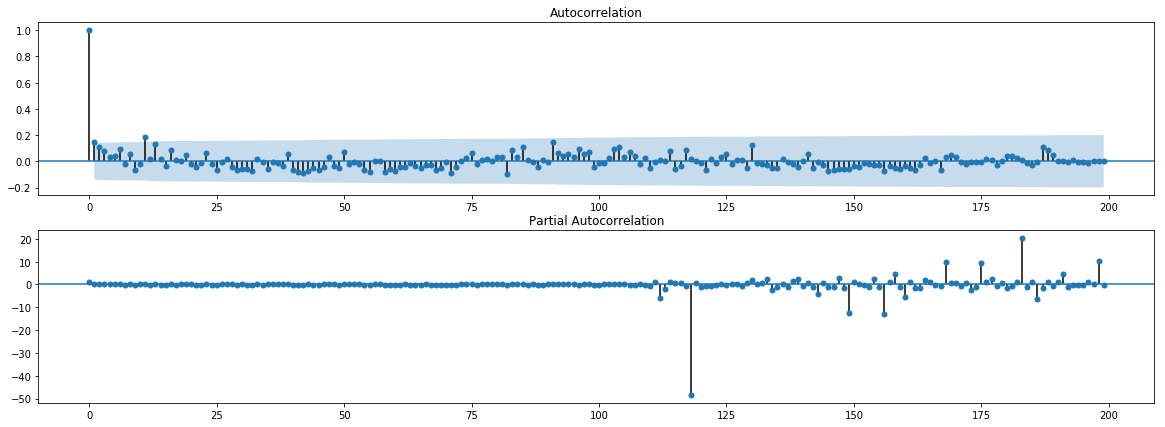

In [379]:
pyplot.figure(figsize=(20,7))
pyplot.subplot(211)
plot_acf(y_oldprospect[len(y_oldprospect)-lag:], ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(y_oldprospect[len(y_oldprospect)-lag:], ax=pyplot.gca())
pyplot.show()

In [377]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [353]:
train, test = y_oldprospect[len(y_oldprospect)-50:len(y_oldprospect)-7], y_oldprospect[len(y_oldprospect)-7:]

In [354]:
model = AR(train)

/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [355]:
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 10
Coefficients: const           4.991
L1.duration     0.004
L2.duration     0.138
L3.duration     0.206
L4.duration     0.162
L5.duration     0.209
L6.duration     0.028
L7.duration     0.030
L8.duration     0.314
L9.duration    -0.380
L10.duration   -0.454
dtype: float64


In [356]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) 
for i in range(len(predictions)):
    print('predicted=%i, expected=%i'%(predictions.iloc[i], test.iloc[i])) 
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

predicted=8, expected=4
predicted=12, expected=5
predicted=9, expected=3
predicted=11, expected=3
predicted=8, expected=8
predicted=9, expected=1
predicted=18, expected=3
Test RMSE: 8.074


/Users/pauldefusco/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
